In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata.logging

import mubind.pl


In [3]:
import seaborn


In [4]:
import mubind as mb

In [5]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [6]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [7]:
pwms = mb.datasets.archetypes()
clu = mb.datasets.archetypes_clu()
anno = mb.datasets.archetypes_anno()


HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
HOCOMOCOv11_core_MOUSE_mono_meme_format.meme
JASPAR2018_CORE_vertebrates_non-redundant_pfms.meme
table_s3-1.meme
table_s3-2.meme
table_s3-3.meme
table_s3-4.meme
table_s3-5.meme
table_s3-6.meme
# motifs loaded 2179


In [8]:
pwms_by_name = {}
for k, pwm in zip(anno['Seed_motif'], pwms):
    pwms_by_name[k] = pwm

In [9]:
reduced_groups = [p.to_numpy() for p in pwms]
# print(len(reduced_groups))

In [10]:
len(reduced_groups)

286

In [11]:
# reduced_groups = reduced_groups[:4]
# reduced_groups = reduced_groups[:1]

In [12]:
for pi, p in enumerate(reduced_groups):
    print(pi, p.shape)

0 (4, 9)
1 (4, 18)
2 (4, 9)
3 (4, 13)
4 (4, 14)
5 (4, 13)
6 (4, 17)
7 (4, 17)
8 (4, 13)
9 (4, 12)
10 (4, 15)
11 (4, 8)
12 (4, 11)
13 (4, 14)
14 (4, 12)
15 (4, 12)
16 (4, 17)
17 (4, 10)
18 (4, 18)
19 (4, 17)
20 (4, 11)
21 (4, 12)
22 (4, 17)
23 (4, 11)
24 (4, 12)
25 (4, 14)
26 (4, 14)
27 (4, 10)
28 (4, 15)
29 (4, 10)
30 (4, 10)
31 (4, 14)
32 (4, 9)
33 (4, 14)
34 (4, 10)
35 (4, 14)
36 (4, 12)
37 (4, 15)
38 (4, 16)
39 (4, 18)
40 (4, 12)
41 (4, 9)
42 (4, 14)
43 (4, 17)
44 (4, 18)
45 (4, 13)
46 (4, 18)
47 (4, 12)
48 (4, 12)
49 (4, 14)
50 (4, 18)
51 (4, 19)
52 (4, 10)
53 (4, 10)
54 (4, 12)
55 (4, 16)
56 (4, 14)
57 (4, 8)
58 (4, 15)
59 (4, 17)
60 (4, 17)
61 (4, 12)
62 (4, 15)
63 (4, 14)
64 (4, 10)
65 (4, 8)
66 (4, 12)
67 (4, 10)
68 (4, 10)
69 (4, 12)
70 (4, 6)
71 (4, 15)
72 (4, 10)
73 (4, 13)
74 (4, 9)
75 (4, 10)
76 (4, 12)
77 (4, 9)
78 (4, 10)
79 (4, 21)
80 (4, 12)
81 (4, 17)
82 (4, 10)
83 (4, 14)
84 (4, 12)
85 (4, 13)
86 (4, 20)
87 (4, 9)
88 (4, 9)
89 (4, 8)
90 (4, 12)
91 (4, 20)
92 (4, 19)


In [13]:
def unfreeze(model, feat_lab=None, position=None):
    # block mononucleotide but free dinucleotide and activities to calibrate themselves during training
    verbose = 1
    for ki in range(2 + 1):
        mask_pos = (ki == position if position is not None else True)
        mask_mono = (feat_lab == 'mono') and mask_pos
        mask_dinuc = (feat_lab == 'dinuc') and mask_pos
        if verbose != 0:
            print("setting grad status of kernel (mono, dinuc) at %i to (%i, %i)" % (ki, mask_mono, mask_dinuc))
        model.binding_modes.update_grad_mono(ki, mask_mono)
        model.binding_modes.update_grad_di(ki, mask_dinuc)

In [14]:
# unfreeze(model, None)
# model.binding_modes.update_grad_mono(0, True)
# model.binding_modes.update_grad_di(0, True)

In [15]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0
Using device: cuda:0


In [16]:
h5ad_path = '../../../../scchipseq_drosophila/s03_glue/ctcf.h5ad'

In [17]:
import scanpy as sc
adata = sc.read_h5ad(h5ad_path)

In [18]:
sc.pp.neighbors(adata, use_rep='X_glue')
sc.tl.umap(adata)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


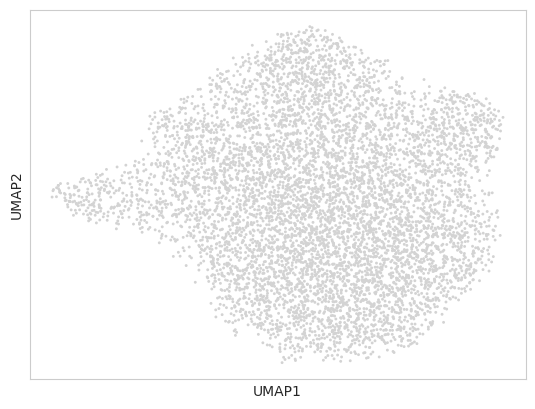

In [19]:
sc.pl.umap(adata)

In [20]:
n_sample_cells = 250 # adata.shape[0]
n_sample_peaks = 500 # adata.shape[1]

In [21]:
np.random.seed(100)

# adata = adata[:,adata.var.modality == 'CTCF'].copy()
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [22]:
adata.shape

(250, 500)

In [23]:
adata

View of AnnData object with n_obs × n_vars = 250 × 500
    obs: 'seurat_clusters', 'modality', 'balancing_weight', 'annotation', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'modality'
    uns: '__scglue__', 'annotation_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_cistopic_umap', 'X_cistopic_zscores', 'X_counts', 'X_glue', 'X_glue_umap', 'X_lsi', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

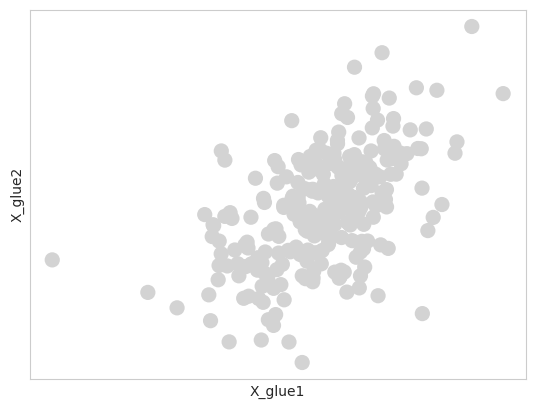

In [24]:
sc.pl.embedding(adata, basis='X_glue')

In [25]:
adata.shape

(250, 500)

In [26]:
adata.var['chr'] = adata.var['chrom']
adata.var['start'] = adata.var['chromStart'].astype(int)
adata.var['end'] = adata.var['chromEnd'].astype(int)

/tmp/ipykernel_5351/2736210229.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['chr'] = adata.var['chrom']


In [27]:
adata.var

,chrom,chromStart,chromEnd,strand,highly_variable,means,dispersions,dispersions_norm,modality,chr,start,end
annot,,,,,,,,,,,,
chr2L:10056492-10057770,chr2L,10056492.0,10057770.0,+,False,0.095213,2.226756,0.352756,CTCF,chr2L,10056492,10057770
chr2L:10857907-10859122,chr2L,10857907.0,10859122.0,-,False,0.035966,1.390525,-0.350596,CTCF,chr2L,10857907,10859122
chr2L:11474623-11475209,chr2L,11474623.0,11475209.0,+,False,0.015932,1.107424,-0.588712,CTCF,chr2L,11474623,11475209
chr2L:11624091-11624603,chr2L,11624091.0,11624603.0,-,False,0.018924,1.181016,-0.526814,CTCF,chr2L,11624091,11624603
chr2L:1169719-1170201,chr2L,1169719.0,1170201.0,-,False,0.017068,1.158008,-0.546166,CTCF,chr2L,1169719,1170201
...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:9667687-9668302,chrX,9667687.0,9668302.0,+,False,0.020057,1.217162,-0.496411,CTCF,chrX,9667687,9668302
chrX:9731397-9731957,chrX,9731397.0,9731957.0,-,False,0.023198,1.640455,-0.140381,CTCF,chrX,9731397,9731957
chrX:9890701-9891447,chrX,9890701.0,9891447.0,-,False,0.048164,1.792815,-0.012231,CTCF,chrX,9890701,9891447


In [28]:
extend = 50

adata.var['chr'].value_counts()

chr2R    120
chr2L    104
chr3R     97
chr3L     94
chrX      75
chr4       8
chrY       2
Name: chr, dtype: int64

In [29]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [30]:
adata.var['k.summit'] = adata.var['chr'].astype(str) + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [31]:
adata.shape

(250, 500)

In [32]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/dm6/genome/dm6.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

convert bed to fasta
/tmp/tmp28r8l0_3
genome mm10 True
../../../annotations/dm6/genome/dm6.fa
True ../../../annotations/dm6/genome/dm6.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/dm6/genome/dm6.fa -bed /tmp/tmp28r8l0_3 -fo /tmp/tmp1r20gnqz
get fasta
/tmp/tmp1r20gnqz


In [33]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [34]:
next_data = pd.DataFrame(counts) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break


next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

next_data.index = [str(i) + '-' + s[1] for i, s in enumerate(seqs)]
next_data.index.name = 'seq'
print(next_data.shape)

n_cells = adata.shape[0]
n_peaks = adata.shape[1]
print('# cells', n_cells)
print('# peaks', n_peaks)
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_peaks]

# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

next_data_sel

del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0

df = df[~zero_counts] # remove zeroes

df.shape

(500, 251)
# cells 250
# peaks 500


(466, 250)

In [35]:
df.index = [v.split('-')[1] for v in df.index]
df.index.name = 'seq'

In [36]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [37]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(116500, 3)
250
0      466
137    466
127    466
128    466
129    466
      ... 
69     466
70     466
71     466
72     466
199    466
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
AAATGGGTGGTTTCATTAATTAACAAATGTTTGGAAAGTACTTTACTCACCTTAAAGGAACATTCACTGGATTTCTCCAACACCGTGGCAGCGCCCTCTA,1.0,0.0,0
GCACTATCGATTACATTGATGCCACTGCGATATTTCGTATTTTTGCGCTTCACAACACTGAATTTTCGTTTGCTAAGGCGCCACCTATCTGCTTAATGTT,1.0,0.0,0
CCTTAGAGGCCTAGCAGGGAGTAAGCGTCTAGCAAGTATACTGTGGTGTCGTCTTAGTCTATCACTATATCTGCTGGTGTGCCTGGAGATCTGCTCTTCC,1.0,1.0,0
TGGCGCTCGTACTTAAACTTTTCTTAATTCTATAGCTGTTGCTAAACTATTTGCCAAAAAAAAAAAACATTGAAATATCAACAAACATGTATAAATTATT,1.0,0.0,0
CGGAAGTAGACCGTAAAGGTGGAGCCACTATACATGAAATGCTCAGCGGAGTTTTTGTTCAAATTTGTGTAGAAATAGGATAGAAATGCGGACCATGTAG,1.0,0.0,0


### This is the relatedness graph and used for dynamics filters learning

In [38]:
# sum(adata.obs_names.isin(df.index)

In [39]:
len(seqs)

500

In [40]:
zero_counts.shape, adata.shape

((500,), (250, 500))

In [41]:
adata.shape

(250, 500)

In [42]:
# adata = adata.T

In [43]:
sc.pp.neighbors(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [44]:
ad = adata[:,~zero_counts].copy()

In [45]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [46]:
n_batch = len(set(dataset.batch))
n_batch

1

In [47]:
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [48]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [49]:
n_kernels = len(reduced_groups)
# n_kernels = 8

In [50]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()
# criterion = torch.nn.CrossEntropyLoss()

w = [r.shape[1] for r in reduced_groups]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=True,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=True,
                                       # optimize_prob_act=True,
                                       # p_dropout=.8,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None,
                                       prepare_knn=True,
                                       p_dropout=0.8,
                                       adata=ad) # .cuda()



In [51]:
model = model.cuda()

If indicating priors, then the model will initialize them from the previous binding modes generated during preparation

In [52]:

# initialize the reduce kernels
for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU


In [53]:
model = model.to(device)


In [54]:
print(model.selex_module.log_dynamic)
print(model.selex_module.log_etas)

Parameter containing:
tensor([0.2949, 0.2783, 0.4881,  ..., 0.7747, 0.0693, 0.3449], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

In [55]:
from IPython.core import ultratb; ultratb.VerboseTB._tb_highlight = "bg:ansired"

In [56]:
# model.prepare_knn(ad)
# if 'cuda' in str(device):
#     model.selex_module = model.selex_module.cuda()

True
12
0 None
0
None
0 out of 288...
1 Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
1
Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
(10, 12) (0, 0) 1
2 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
2
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(10, 12) (0, 1) 1
3 Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
3
Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
(10, 12) (0, 2) 1
4 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
4
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(10, 12) (0, 3) 1
5 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
5
Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)


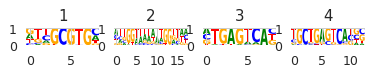

In [57]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=10, n_cols=12, stop_at=5) # n_cols=len(reduced_groups))

In [58]:
# model.binding_modes.prob_act

In [59]:
mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})
# mb.pl.conv(model, n_cols=2)


In [60]:
n_epochs_intercept = 150
n_epochs_kernel = 150

model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                            show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                            opt_one_step=True,
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            skip_kernels=range(1, 500),
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                            exp_max=8,
                                            early_stopping=250, log_each=1, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

In [61]:
model.binding_modes.prob_act

Parameter containing:
tensor([ 1.1945,  1.0202,  1.1642,  1.0428,  1.0239,  1.0446,  1.0165,  1.0128,
         1.0345,  1.0481,  1.0290,  1.1201,  1.0751,  1.0289,  1.0405,  1.0485,
         1.0180,  1.0616,  1.0075,  1.0150,  1.0579,  1.0509,  1.0065,  1.0541,
         1.0550,  1.0436,  1.0213,  1.1331,  1.0297,  1.1142,  1.0736,  1.0409,
         1.1544,  1.0296,  1.0756,  1.0380,  1.0470,  1.0294,  1.0062,  1.0011,
         1.0514,  1.1410,  1.0134,  1.0126,  1.0049,  1.0198,  1.0003,  1.0453,
         1.0358,  1.0213,  1.0100,  1.0113,  1.1089,  1.0885,  1.0588,  1.0228,
         1.0267,  0.4207,  1.0263,  1.0102,  1.0190,  1.0319,  1.0140,  1.0229,
         1.1286,  0.8510,  1.0400,  1.0653,  1.0503,  1.0412, -0.2031,  1.0241,
         1.0765,  1.0434,  1.1534,  1.0865,  1.0529,  1.1816,  1.0923,  1.0132,
         1.0489,  1.0000,  1.1037,  1.0000,  1.0344,  1.0000,  1.0093,  1.1190,
         1.1965, -0.1878,  1.0596,  1.0006,  1.0071,  1.1242,  1.0396,  1.0354,
         1.0209,  

In [62]:
model.activities.log_activities[0].requires_grad

True

In [63]:
print(model.selex_module.log_dynamic)
# print(model.selex_module.log_etas)

Parameter containing:
tensor([ 6.2973e-01, -4.3069e-04,  2.4722e-01,  ...,  1.4179e+00,
         4.6835e-01,  4.6498e-01], device='cuda:0', requires_grad=True)


Text(0, 0.5, 'similar weights loss')

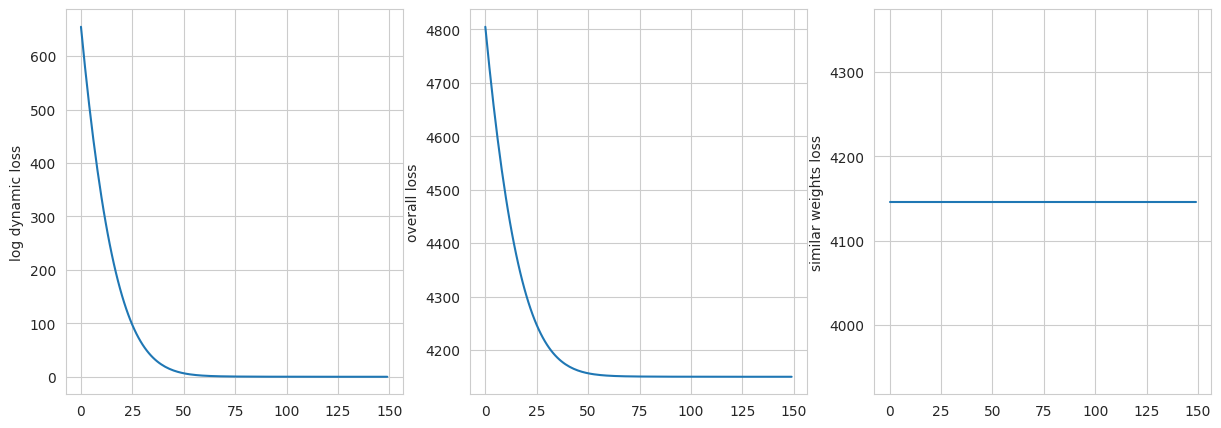

In [64]:
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')


In [65]:
print('here...')

here...


True
12
0 None
0
None
0 out of 288...
1 Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
1
Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
(10, 12) (0, 0) 1
2 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
2
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(10, 12) (0, 1) 1
3 Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
3
Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
(10, 12) (0, 2) 1
4 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
4
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(10, 12) (0, 3) 1
5 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
5
Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
(10, 12) (0, 4) 1
6 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
6
Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
(10, 12) (0, 5) 1
7 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
7
Conv2d(1, 1, kernel_size=(4, 13), strid

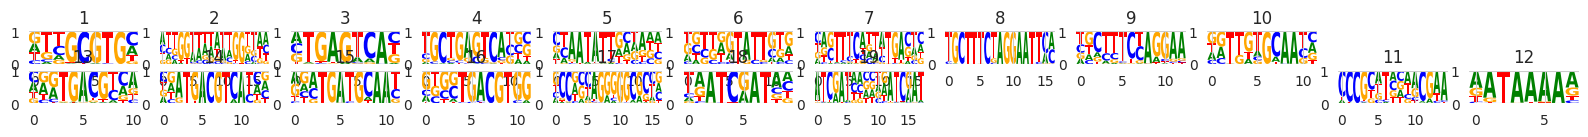

In [66]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=12, n_rows=10, show=True, stop_at=20)
plt.show()


In [67]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

tensor(indices=tensor([[  0,   0,   0,  ..., 226, 242, 248],
                       [  2,   8,  14,  ..., 249, 249, 249]]),
       values=tensor([ 6.2973e-01, -4.3069e-04,  2.4722e-01,  ...,
                      -1.4179e+00, -4.6835e-01, -4.6498e-01]),
       device='cuda:0', size=(250, 250), nnz=12688, layout=torch.sparse_coo,
       grad_fn=<AddBackward0>)

<AxesSubplot: >

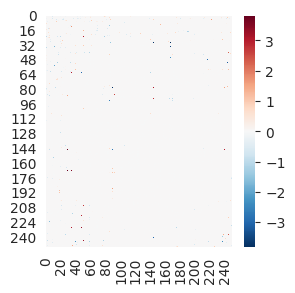

In [68]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

In [69]:
model.best_r2_by_new_filter

[]

In [70]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
if len(model.best_r2_by_new_filter) != 0:
    r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
    sns.barplot(data=r2, x='index', y='r2')

In [71]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
if len(model.best_r2_by_new_filter) != 0:
    r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
    sns.barplot(data=r2, x='index', y='r2')

In [72]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [73]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

Text(0.5, 7.555555555555548, 'dynamic score (normalized)')

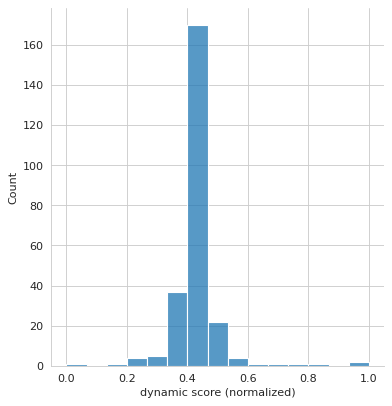

In [74]:
ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > dynamic_score.quantile(.66), 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > dynamic_score.quantile(.95), 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score, bins=15)
plt.xlabel('dynamic score (normalized)')


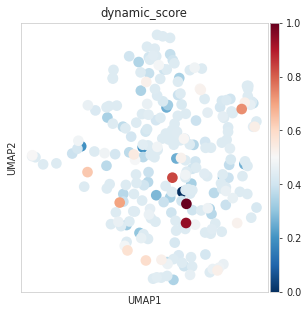

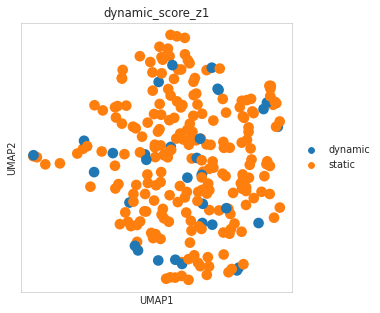

In [75]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 70
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [76]:
ad.obs['dynamic_score_z1']

barcode
CTCF_ACGCGACGCAATTCGTCGCCGATC     static
CTCF_ACGCGACGCAGCCATGCCTTCACC     static
CTCF_ACGCGACGCGGAGCGTCAATTAAC    dynamic
CTCF_ACGCGACGCTCAGAATGGACTTGG     static
CTCF_ACGCGACGGGACTTATAAGTCCAA     static
                                  ...   
CTCF_TTCATCGTGGCTGCGATAAGGTCA    dynamic
CTCF_TTCATCGTGGCTGCGATATCGCAC     static
CTCF_TTCATCGTTGACGCGACGCCGATC    dynamic
CTCF_TTCATCGTTGACGCGATTCCTGTT     static
CTCF_TTCATCGTTGGATCGTGACGTCTT     static
Name: dynamic_score_z1, Length: 250, dtype: category
Categories (2, object): ['dynamic', 'static']

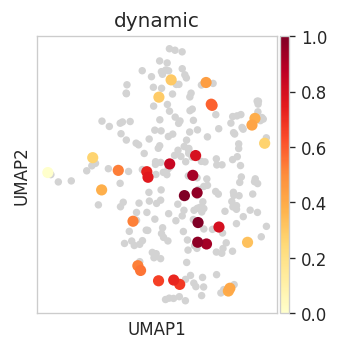

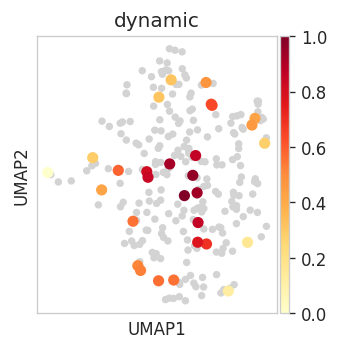

In [77]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 120

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [78]:
sc.set_figure_params()

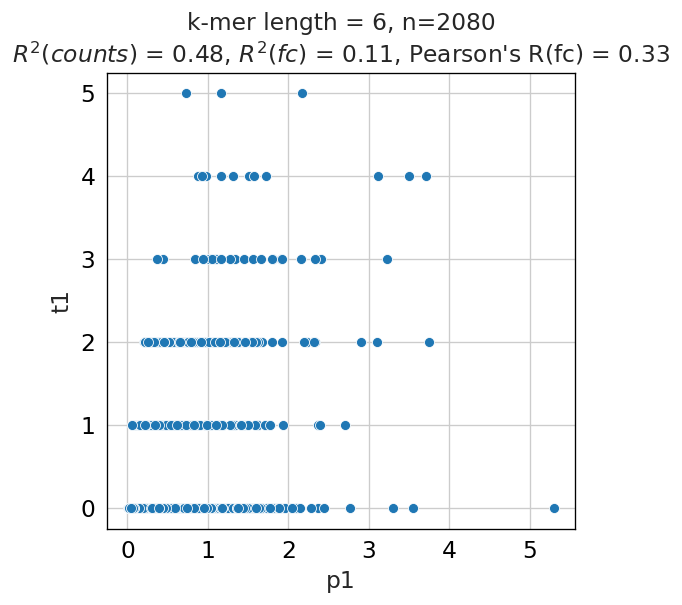

{'r2_counts': 0.47781391280508523,
 'r2_foldchange': 0.01812736954606986,
 'r2_enr': 0.01345027756087458,
 'r2_fc': 0.10902311382131853,
 'pearson_foldchange': 0.3301864834019081}

In [79]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 60})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=6)


In [80]:
umap = ad.obsm['X_umap'].copy()
umap = np.sort(umap, 0)

x = umap[:,0]
y = umap[:,1]
X, Y = np.meshgrid(x, y)

n_points = x.shape[0]
# x-component to the right
u = np.ones((n_points, n_points))
# y-component zero
v = np.zeros((n_points, n_points))

In [81]:
D.shape

torch.Size([250, 250])

In [82]:
import scvelo as scv

In [83]:
ad.shape

(250, 466)

In [84]:
log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
log_act.shape

torch.Size([250, 288])

In [85]:
train.dataset.mononuc.shape

(466, 4, 100)

In [86]:
pred = []
for i, batch in enumerate(train):
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"].to(device)
    # print(i, mononuc.shape)
    b = batch["batch"].to(device) if "batch" in batch else None
    rounds = batch["rounds"].to(device) if "rounds" in batch else None
    countsum = batch["countsum"].to(device) if "countsum" in batch else None
    seq = batch["seq"] if "seq" in batch else None
    residues = batch["residues"].to(device) if "residues" in batch else None
    if residues is not None and train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                  "residues": residues}
    elif residues is not None:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
    elif train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
    else:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

    inputs['scale_countsum'] = model.datatype == 'selex'
    output = model(**inputs, use_conn=False)

    output = output.cpu().detach().numpy()
    print('here...')
    print(output.shape)

    print(output.sum())
    pred.append(output)

pred = np.concatenate(pred).T
ad.layers['velocity'] = pred
ad.layers['counts'] = ad.X

here...
(466, 250)
6516.9995


In [87]:
ad.layers['counts']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

(array([1066., 2202., 1302.,  458.,  332.,  180.,  128.,   90.,   56.,
         530.]),
 array([1.47953131e-06, 1.00001335e-01, 2.00001180e-01, 3.00001025e-01,
        4.00000900e-01, 5.00000715e-01, 6.00000620e-01, 7.00000465e-01,
        8.00000310e-01, 9.00000155e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

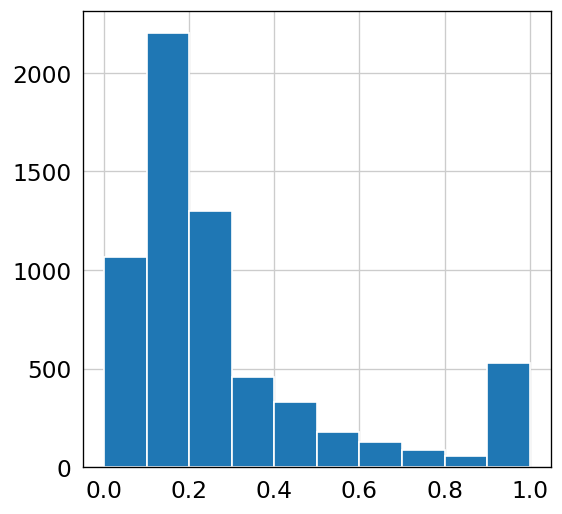

In [88]:
plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())

In [89]:
pred.shape

(250, 466)

In [90]:
ad.shape

(250, 466)

In [91]:
sc.pp.neighbors(ad)

In [92]:
# ad.layers['log_act'] = dyn_umap.X
# ad.layers['counts'] = ad.X
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')

computing velocity graph (using 1/16 cores)


  0%|          | 0/250 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


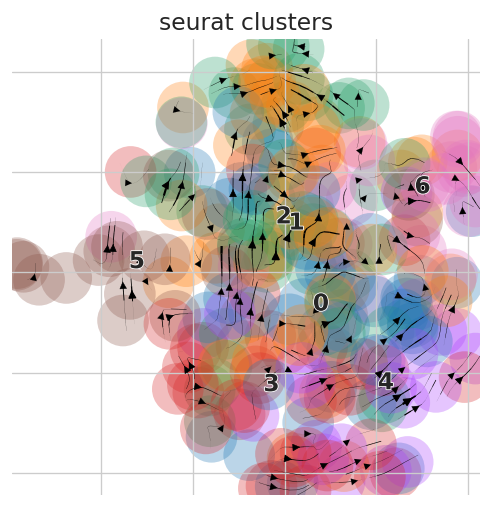

In [93]:
scv.pl.velocity_embedding_stream(ad, color='seurat_clusters') #  X_grid='X_umap', V=V)


In [94]:
ad.shape

(250, 466)

In [95]:
act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
# log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
# log_act


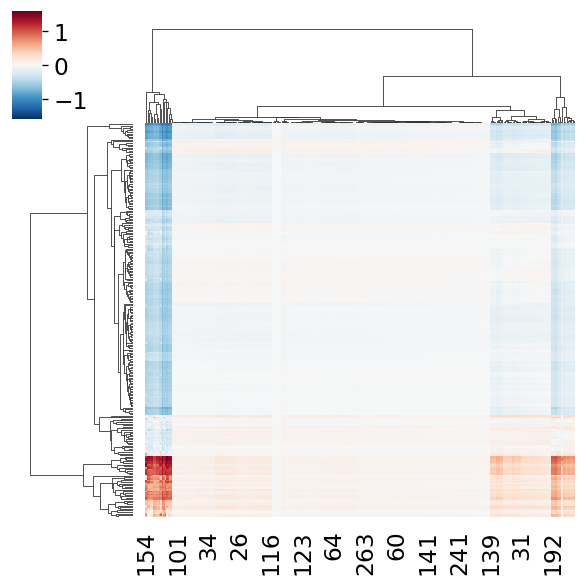

In [96]:
vmax = act.abs().max()
sns.clustermap(act.detach().cpu().numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

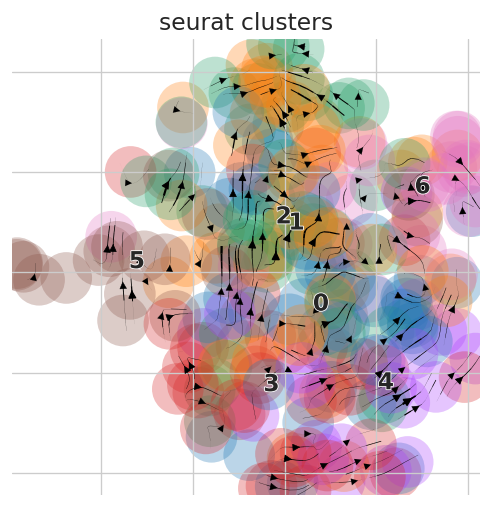

In [97]:

scv.pl.velocity_embedding_stream(ad, color='seurat_clusters') #  X_grid='X_umap', V=V)


In [98]:
log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
log_act = pd.DataFrame(log_act.detach().cpu().numpy())
# log_act.columns = anno['Seed_motif'][2]
log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
log_act.index = ad.obs_names
ad.obsm['mubind_activities'] = log_act
for c in ad.obsm['mubind_activities']:
    ad.obs[c] = ad.obsm['mubind_activities'][c]

Text(0.5, 1.0, 'TF modules (by score)')

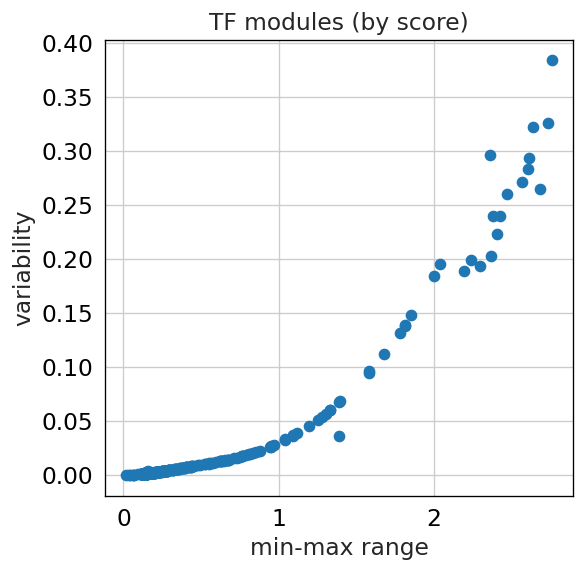

In [99]:

delta = (log_act.max(axis=0) - log_act.min(axis=0))
var = log_act.var(axis=0)
plt.scatter(delta, var)
plt.xlabel('min-max range')
plt.ylabel('variability')
plt.title('TF modules (by score)')

In [100]:
scores = pd.concat([delta, var], axis=1)
scores['combined'] = scores.sum(axis=1)
scores.sort_values('combined', ascending=False)
scores['idx'] = np.arange(scores.shape[0])

In [101]:
scores

,0,1,combined,idx
intercept,0.019794,0.000004,0.019798,0
dinuc_bias,2.040747,0.195768,2.236515,1
AHR_HUMAN.H11MO.0.B,0.176998,0.001799,0.178797,2
AIRE_HUMAN.H11MO.0.C,1.395847,0.068148,1.463995,3
ATF3_MOUSE.H11MO.0.A,0.365626,0.006034,0.371661,4
...,...,...,...,...
ZNF784_C2H2_1,0.112535,0.000746,0.113281,283
ZNF85_HUMAN.H11MO.0.C,0.144598,0.002023,0.146620,284
ZNF8_HUMAN.H11MO.0.C,0.172542,0.001677,0.174219,285
ZSC31_HUMAN.H11MO.0.C,0.164766,0.001428,0.166195,286


In [102]:
gene_query = 'CTCF'
names_query = anno[anno['Cluster_ID'].isin(set(clu[clu['Motif'].str.contains(gene_query)]['Cluster_ID'].values))]['Seed_motif'].values
names_query


array(['CTCFL_HUMAN.H11MO.0.A'], dtype=object)

In [103]:
# top_idx = scores.sort_values('combined', ascending=False).head(5).index
# idx_mb_model = scores.sort_values('combined', ascending=False).head(5)['idx'].values
top_idx = scores.head()[2:8].index
idx_mb_model = scores.head()['idx'].values[2:8]

In [104]:
idx_mb_model

array([2, 3, 4])

In [105]:
top_idx, idx_mb_model

(Index(['AHR_HUMAN.H11MO.0.B', 'AIRE_HUMAN.H11MO.0.C', 'ATF3_MOUSE.H11MO.0.A'], dtype='object'),
 array([2, 3, 4]))

In [106]:
# top_idx = [0, 1, 2, 3]

AHR_HUMAN.H11MO.0.B
AIRE_HUMAN.H11MO.0.C
ATF3_MOUSE.H11MO.0.A
0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)


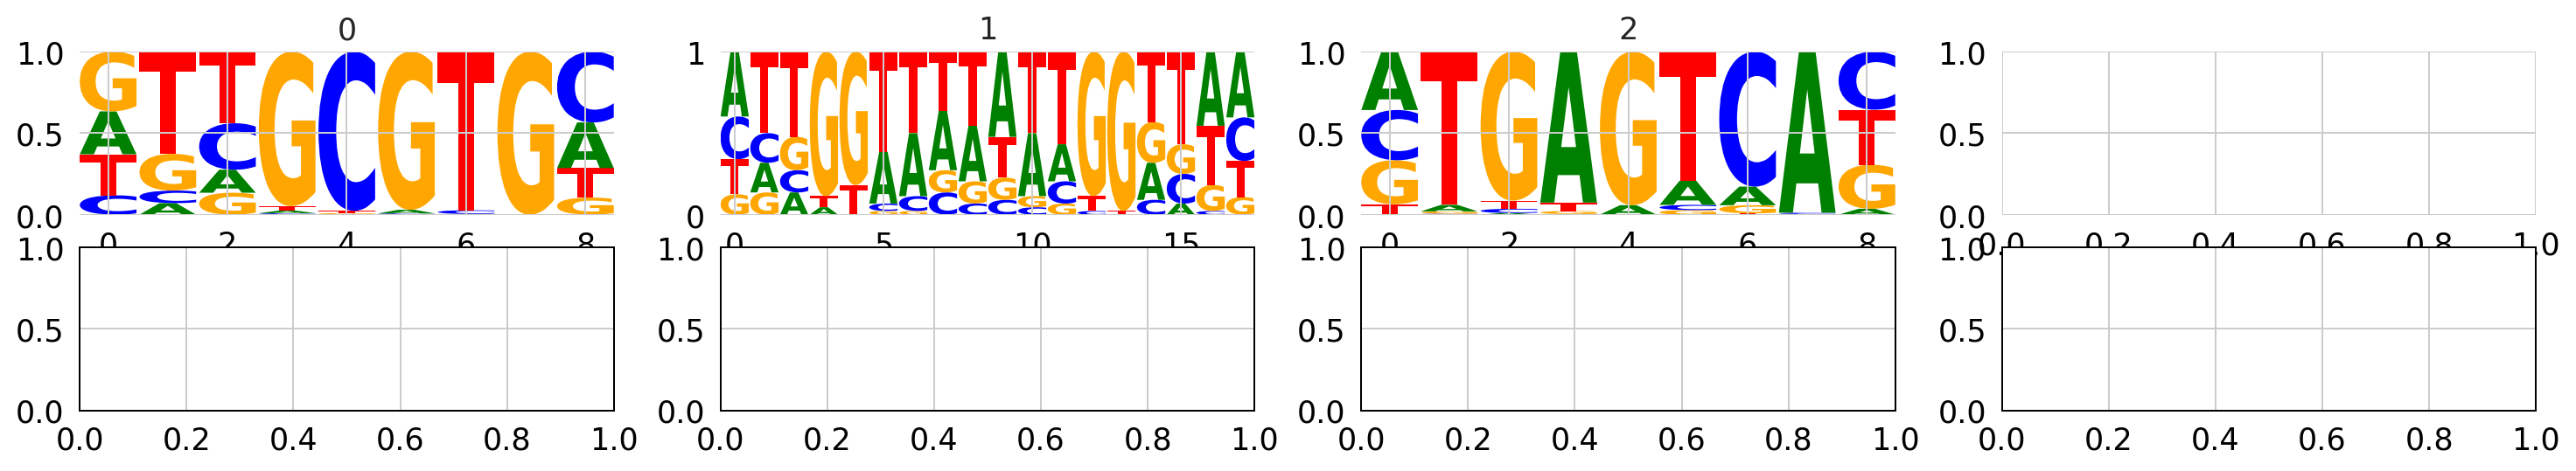

In [107]:
mb.pl.set_rcParams({'figure.figsize': [20, 3], 'figure.dpi': 90})
for k in top_idx:
    print(k)
mb.pl.conv_mono(weights_list=[pwms_by_name[k] for k in top_idx], n_cols=4, n_rows=2)

0 1 (4, 9)
1 2 (4, 18)
2 3 (4, 9)


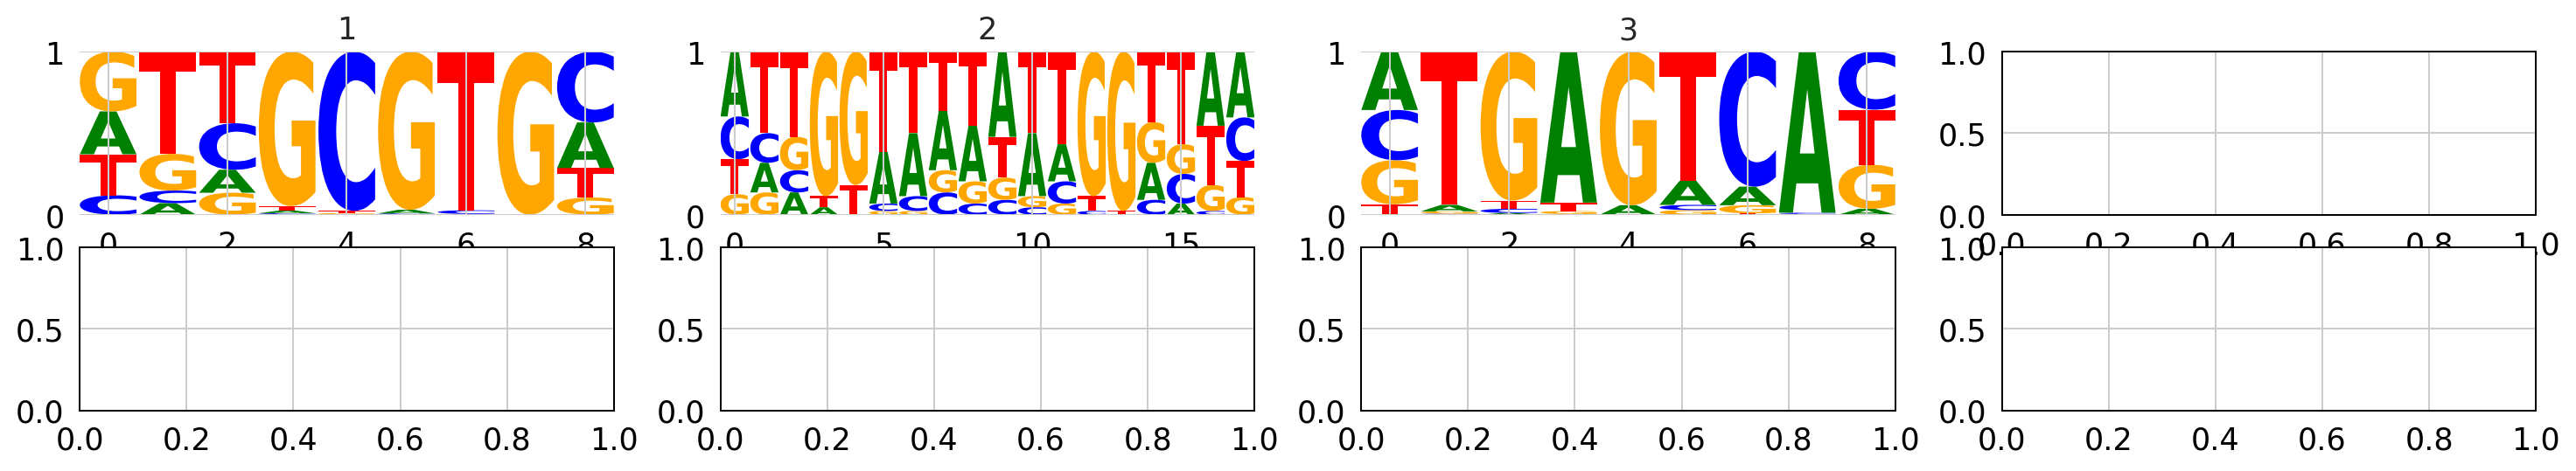

In [108]:
mb.pl.conv_mono(model, subset=[idx - 1 for idx in idx_mb_model], n_cols=4, n_rows=2)

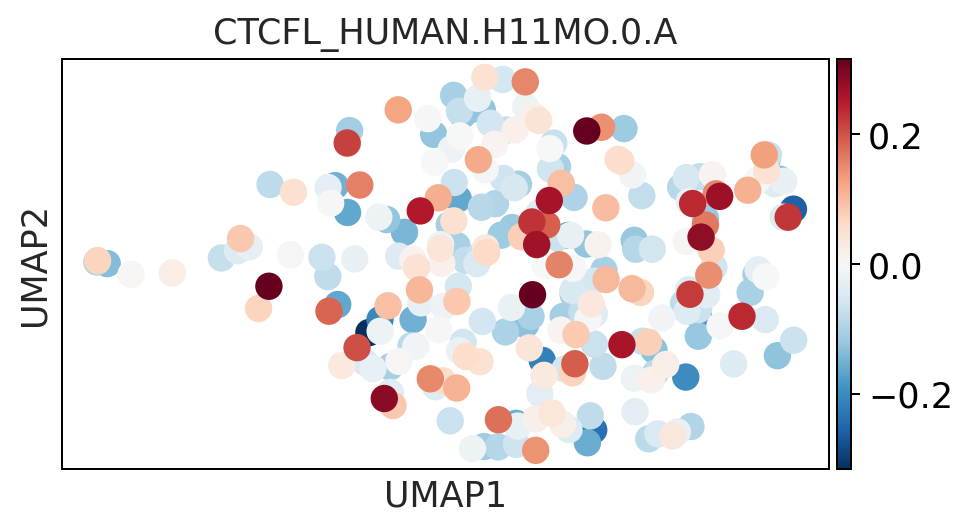

In [109]:
mb.pl.set_rcParams({'figure.figsize': [6, 3], 'figure.dpi': 90})
sc.pl.umap(ad, color=names_query, cmap='RdBu_r')

AHR_HUMAN.H11MO.0.B
AIRE_HUMAN.H11MO.0.C
ATF3_MOUSE.H11MO.0.A
0 1 (4, 9)
1 2 (4, 18)
2 3 (4, 9)


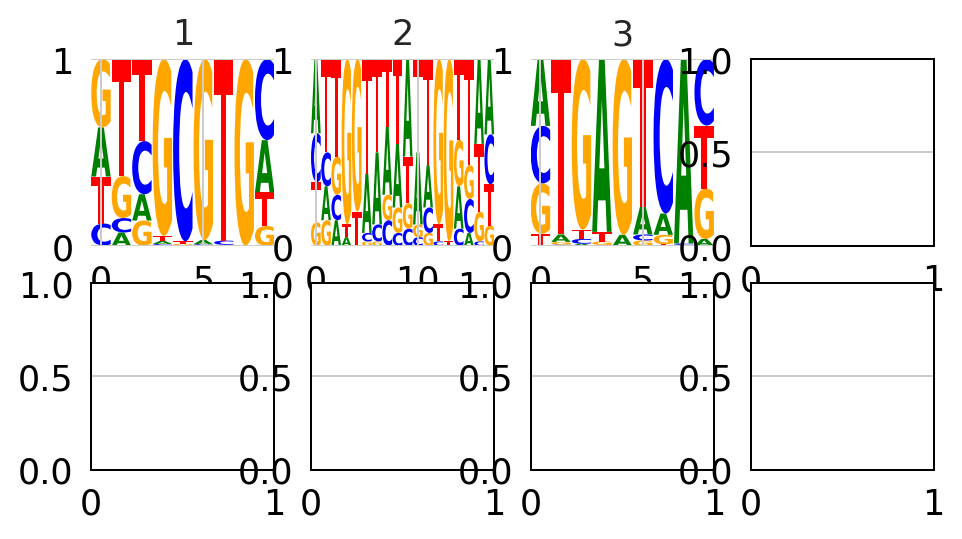

In [110]:
for k in top_idx:
    print(k)


# model
mb.pl.conv_mono(model, subset=[idx - 1 for idx in idx_mb_model], n_cols=4, n_rows=2)


In [111]:
pwms_show = [np.log2((pwms_by_name[k] + 1e-3) / (0.25) + 1e-3) for k in pwms_by_name][:20]

In [112]:
for i, pwm in enumerate(pwms_show):
    pwm[pwm < 0] = 0

0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)
3 3 (4, 13)
4 4 (4, 14)
5 5 (4, 13)
6 6 (4, 17)
7 7 (4, 17)
8 8 (4, 13)
9 9 (4, 12)
10 10 (4, 15)
11 11 (4, 8)
12 12 (4, 11)
13 13 (4, 14)
14 14 (4, 12)
15 15 (4, 12)
16 16 (4, 17)
17 17 (4, 10)


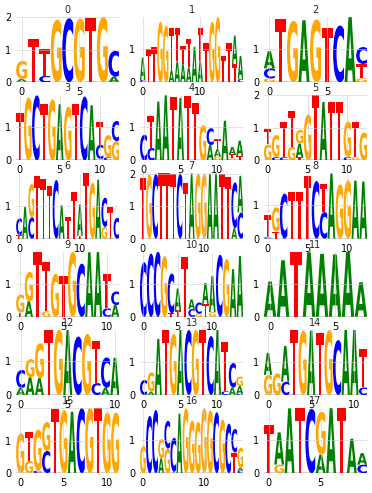

In [113]:
# original pwms
mb.pl.set_rcParams({'figure.figsize': [9, 12], 'figure.dpi': 25})
mb.pl.conv_mono(weights_list=pwms_show,
                n_cols=3, n_rows=6)

0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)


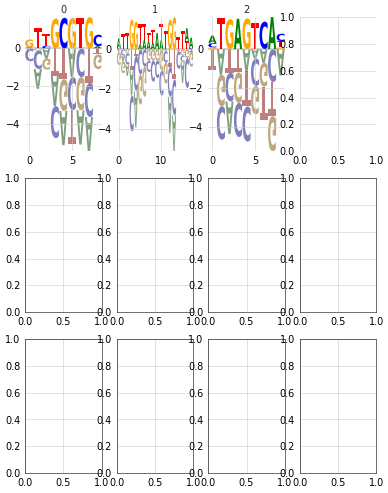

In [114]:
mb.pl.conv_mono(weights_list=[np.log2((pwms_by_name[k] + .1) / (0.25 + .1)) for k in top_idx], n_cols=4, n_rows=3)

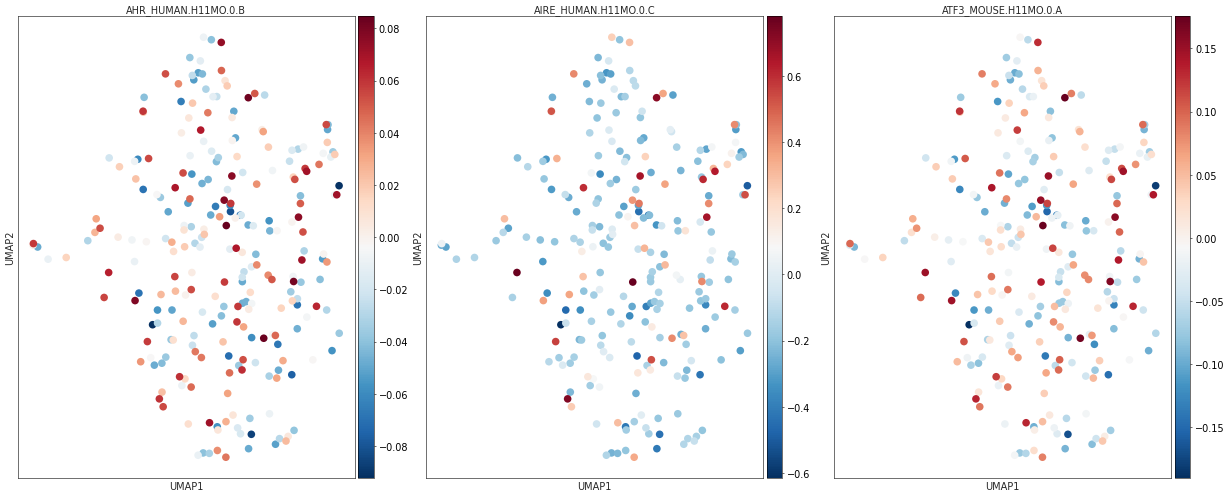

In [115]:
sc.pl.umap(ad, color=top_idx, cmap='RdBu_r')

In [116]:
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()


NameError: name 'rna' is not defined

In [ ]:
rna_sel.var[rna_sel.var_names.str.startswith('Neu')]

In [ ]:
rna.var_names[rna.var_names == 'Neurog3']

In [ ]:
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'

In [ ]:
anno.columns

In [ ]:
# sns.clustermap(log_act.detach().numpy())

In [ ]:
for i in range(2, log_act.shape[1]):
    print(i)

In [ ]:
log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
log_act = pd.DataFrame(log_act.detach().cpu().numpy())
# log_act.columns = anno['Seed_motif'][2]
log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
log_act.index = ad.obs_names
ad.obsm['mubind_activities'] = log_act

In [ ]:
for c in ad.obsm['mubind_activities']:
    ad.obs[c] = ad.obsm['mubind_activities'][c]

In [ ]:
names_neurog = anno[anno['Cluster_ID'].isin(set(clu[clu['Motif'].str.contains('NEU')]['Cluster_ID'].values))]['Seed_motif'].values


In [ ]:
names_clu = list(anno['Seed_motif'].values)

In [ ]:

sc.pl.umap(ad, color=['celltype', 'dinuc_bias'] + list(names_neurog), cmap='RdBu_r', ncols=5)


In [ ]:
sns.clustermap(log_act, cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

In [ ]:
delta = (log_act.max(axis=0) - log_act.min(axis=0))
var = log_act.var(axis=0)
plt.scatter(delta, var)
plt.xlabel('min-max range')
plt.ylabel('variability')
plt.title('TF modules (by score)')

In [ ]:
sns.clustermap(log_act, cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

In [ ]:
sc.pl.umap(ad, color=names_clu[:20], cmap='RdBu_r', ncols=7)


In [ ]:
rna_sel.obs['score'] = log_act[:,63].detach().cpu().numpy()

In [ ]:
sc.pl.umap(rna_sel, color=['celltype', 'score', 'dinuc_bias'], cmap='RdBu_r')
